In [1]:
# import libraries 
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Set of functions



def get_dynamics(graph, params, plot=False):
    """
    Function to get the dynamics of the graph
    """
    # Parameters
    alpha = params['alpha']
    beta = params['beta']
    delta = params['delta']
    do = params['do']
    I = params['I']
    rho_ss = params['rho_ss']
    O_ss = params['O_ss']
    lambda_c = params['lambda_c']
    G = graph
    n = len(G.nodes())
    A = nx.adjacency_matrix(G).todense()

    
    def system(t, y, A, alpha, beta, delta, do, I):
        """
        y[k][0] is rho
        y[k][1] is O
        n repetitions for each municipality
        2 variables, rho and O
        """


        y = y.reshape(n, 2)
        
        dydt = np.zeros_like(y)

        

        def function_1(j):
            return A[i][j] * (y[j][0] - y[i][0])
        
        def function_2(j):
            return A[i][j] * ((y[i][1]/y[j][1])**I * y[j][0] - (y[j][1]/y[i][1])**I * y[i][0])
        
        def function_3(j):
            return A[i][j] * (y[j][1] - y[i][1])
        
        j = np.arange(16)
        

        for i in range(n):
            f_1_j = np.vectorize(function_1)(j)
            f_2_j = np.vectorize(function_2)(j)
            f_3_j = np.vectorize(function_3)(j)
            dydt[i, 0] = -y[i, 0] * y[i, 1] + alpha + np.sum(f_1_j) + np.sum(f_2_j)
            dydt[i, 1] = -delta * y[i, 1] + beta + y[i, 0] * y[i, 1] + do * np.sum(f_3_j)

        return dydt.flatten()
    # Initial conditions
    np.random.seed(0)
    y0 = np.random.uniform(0.01, 2, n * 2)

    # Time span
    t_span = (0, 1000)
    t_eval = np.linspace(*t_span, 100)

    # Solve the system of ODEs
    print("Starting the integration...")
    solution = sp.integrate.solve_ivp(system, t_span, y0, args=(A, alpha, beta, delta, do, I), t_eval=t_eval)
    print("Integration finished.")

    t = solution.t
    y = solution.y.reshape(n, 2, -1)

    # Extract the stationary state from the dynamics (the last values)
    nodes = np.arange(1, n + 1)
    last_values_rho = np.zeros(n)
    last_values_O = np.zeros(n)
    for i in range(n):
        last_values_rho[i] = y[i, 0][-1]
        last_values_O[i] = y[i, 1][-1]

    print("Linear algebra computations...")
    # Computing the spectrum of the Laplacian matrix
    L = -1 * nx.laplacian_matrix(G).todense()

    eigenvalues, eigenvectors = np.linalg.eig(L)

    # get the index of the nearest eigenvalue to lambda_c
    index_lambda_c = np.argmin(np.abs(eigenvalues - lambda_c))
    critical_eigenvector = eigenvectors[:, index_lambda_c]
    

    

    if plot:
        
        # Creating the stem plots
        fig, axes = plt.subplots(3, 1, figsize=(10, 10))

        axes[0].stem(nodes, last_values_rho, linefmt='gray', markerfmt='ko', basefmt=' ', bottom=rho_ss)
        axes[0].axhline(rho_ss, color='red', linestyle='--')


        # Labeling the axes
        axes[0].set_xlabel('Nodes')
        axes[0].set_ylabel('rho')

        axes[1].stem(nodes, last_values_O, linefmt='gray', markerfmt='ko', basefmt=' ', bottom=O_ss)
        axes[1].axhline(O_ss, color='red', linestyle='--')

        # Labeling the axes
        axes[1].set_xlabel('Nodes')
        axes[1].set_ylabel('O')

        axes[2].stem(nodes, critical_eigenvector, linefmt='gray', markerfmt='ko', basefmt=' ')
        axes[2].axhline(0, color='red', linestyle='--')

        # Labeling the axes
        axes[2].set_xlabel('Nodes')
        axes[2].set_ylabel('eigenvector')

        # Display the plot
        plt.show()

    # Variance 
    variance_rho = np.var(last_values_rho)
    variance_O = np.var(last_values_O)
    variance_eigenvector = np.var(critical_eigenvector)

    # Inverse Participation Ratio (IPR)
    ipr_rho = np.sum(last_values_rho**4) / (np.sum(last_values_rho**2)**2)
    ipr_O = np.sum(last_values_O**4) / (np.sum(last_values_O**2)**2)
    ipr_eigenvector = np.sum(critical_eigenvector**4) / (np.sum(critical_eigenvector**2)**2)

    # Network average degree
    k_avg = nx.average_node_connectivity(G)

    print("Computations finished.")
    
    



    # Return the results
    return {
        'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
        'last_values_rho': last_values_rho.tolist(),
        'last_values_O': last_values_O.tolist(),
        'critical_eigenvector': critical_eigenvector.tolist(),
        'variance_rho': float(variance_rho),
        'variance_O': float(variance_O),
        'variance_eigenvector': float(variance_eigenvector),
        'ipr_rho': float(ipr_rho),
        'ipr_O': float(ipr_O),
        'ipr_eigenvector': float(ipr_eigenvector),
        'k_avg': float(k_avg),
    }
        


        


    

In [3]:
# Create an empty graph
G = nx.Graph()

# Add nodes
nodes = range(1, 17)
G.add_nodes_from(nodes)

# Add edges based on the visual structure
edges = [
    (1, 2), (1, 3), (1, 4), (2, 4), (2,5), (3, 4), (3, 6), (3, 7), (3, 8), (4, 5), (4, 8), (4, 9),
    (5, 9), (6, 7), (7, 8), (7, 11), (7, 10), (7, 13), (8, 9), (8, 11), (8, 12), (9, 12),
    (10, 13), (11, 12), (11, 13), (11, 14), (12, 14), (12, 15), (13, 14), (13, 16) ,(14, 15),
    (14, 16), (15, 16)
]
G.add_edges_from(edges)

# Set parameters
alpha = 0.0050415
beta = 0.000013047
delta = 0.0079639
do = 0.0017783
numerator = 2 * delta**2 * beta + do * (alpha + beta)**2 + 2 * (alpha + beta) * delta * np.sqrt(2 * do * (alpha + beta))
denominator = 2 * alpha * delta**2
Ic = numerator / denominator
I = Ic

# Critical eigenvalue, must be 1.19198455
lambda_c = (do * (alpha + beta)**2 + 2 * beta * delta**2 - 2 * I * alpha * delta**2) / (4 * do * delta * (alpha + beta))

# Compute the homogeneous steady states
rho_ss = alpha * delta / (alpha + beta)
O_ss = (alpha + beta) / delta
params = {
    'alpha': alpha,
    'beta': beta,
    'delta': delta,
    'do': do,
    'I': I,
    'rho_ss': rho_ss,
    'O_ss': O_ss,
    'lambda_c': lambda_c
}

In [4]:
params

{'alpha': 0.0050415,
 'beta': 1.3047e-05,
 'delta': 0.0079639,
 'do': 0.0017783,
 'I': np.float64(0.6074034423516578),
 'rho_ss': 0.007943343261028139,
 'O_ss': 0.6346823792363039,
 'lambda_c': np.float64(-1.1921299735869972)}

Starting the integration...
Integration finished.
Linear algebra computations...


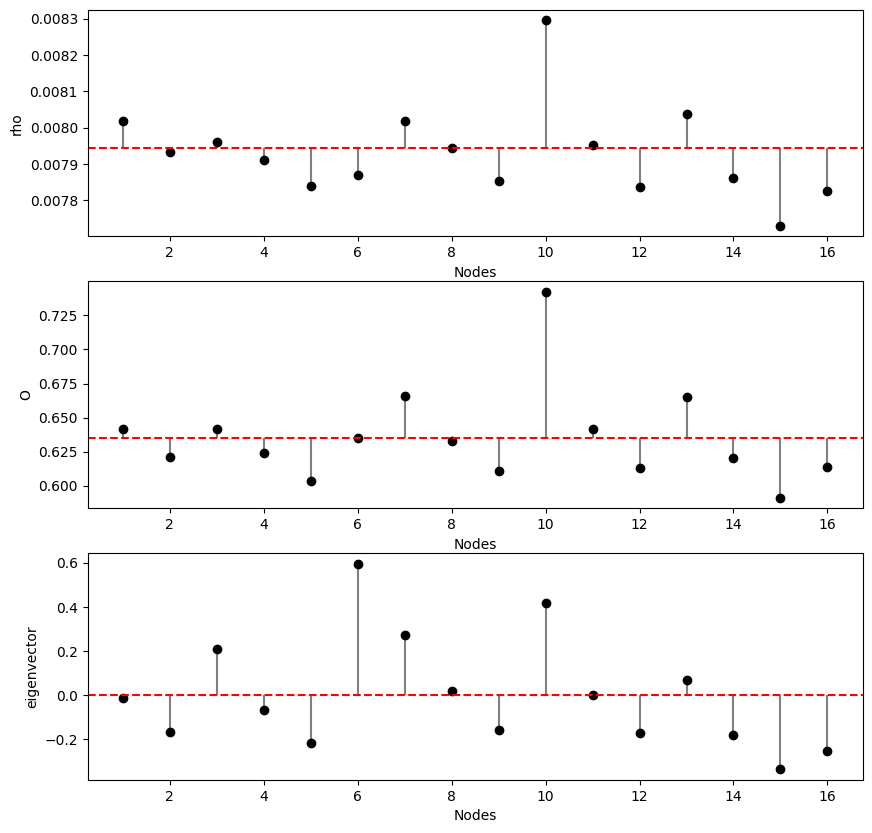

Computations finished.


{'critical_eigenvalue': -1.192131278815221,
 'last_values_rho': [0.008017673334512195,
  0.00793350721019377,
  0.00796141120435202,
  0.007910429647288523,
  0.007837894091806439,
  0.00786874652000212,
  0.00801754479493782,
  0.007943808864420709,
  0.00785369597402932,
  0.008296083769620075,
  0.007952092582323165,
  0.007836025268169603,
  0.008037116412300592,
  0.007861852947671038,
  0.007729125810132597,
  0.007823897028967125],
 'last_values_O': [0.6412709440781548,
  0.6213479973638536,
  0.6412666904228002,
  0.624109646175355,
  0.6035324520220178,
  0.6347099576790894,
  0.6657111877147667,
  0.6326464096277399,
  0.6106922453990723,
  0.742404196281229,
  0.6418976936765375,
  0.6132319109439348,
  0.6653171887294664,
  0.6206441044031115,
  0.5911391154092336,
  0.6136792131018968],
 'critical_eigenvector': [-0.014136992519184132,
  -0.16672971189158284,
  0.21017903177304467,
  -0.06900714646851831,
  -0.2182812920332394,
  0.5960491453376587,
  0.27135042903417467,
 

In [5]:
get_dynamics(G, params, plot=True)

In [ ]:
# Create the experiments

def experiments(n_nodes, n_neighbors, n_experiments, sample_size, params):
    print("Starting the experiments...")
    transitivity = []
    average_path_length = []
    p_values = np.logspace(-4, 0, n_experiments)
    small_world_graphs = []

    # List that will contain the dynamics of the graphs
    dynamics_data = {}
    # Max clustering coefficient
    max_clustering = 3/4 * (n_neighbors - 2) / (n_neighbors - 1)
    # Max length
    max_length = n_nodes / (2 * n_neighbors)

    # Compute the transitivity and average length path for each graph
    for i, p in enumerate(p_values):
        print(f"Computing graph {i + 1}/{n_experiments}...")
        small_world_graphs = []
        transitivities = []
        avg_lenghts = []
        dynamics = []
        print("Computing samples...")
        for seed in range(sample_size):
            small_world_graphs.append(nx.newman_watts_strogatz_graph(n=n_nodes, k=n_neighbors, p=p, seed=seed))
        print("Computing dynamics...")
        transitivities = list(map(lambda x: nx.transitivity(x) / max_clustering, small_world_graphs))
        avg_lenghts = list(map(lambda x: nx.average_shortest_path_length(x) / max_length, small_world_graphs))  
        dynamics = list(map(lambda x: get_dynamics(x, params), small_world_graphs))
        
        
        transitivity.append(np.mean(transitivities))
        average_path_length.append(np.mean(avg_lenghts))
        dynamics_data[p] = dynamics

    # Save the data for each p
    data_ipr_rho = sum([list(map(lambda x: x['ipr_rho'], dynamics_data[p])) for p in p_values], [])
    data_ipr_O = sum([list(map(lambda x: x['ipr_O'], dynamics_data[p])) for p in p_values], [])
    data_ipr_eigenvector = sum([list(map(lambda x: x['ipr_eigenvector'], dynamics_data[p])) for p in p_values], [])
    data_variance_rho = sum([list(map(lambda x: x['variance_rho'], dynamics_data[p])) for p in p_values], [])
    data_variance_O = sum([list(map(lambda x: x['variance_O'], dynamics_data[p])) for p in p_values], [])
    data_variance_eigenvector = sum([list(map(lambda x: x['variance_eigenvector'], dynamics_data[p])) for p in p_values], [])
    data_k_avg = sum([list(map(lambda x: x['k_avg'], dynamics_data[p])) for p in p_values], [])
    
    data_p = sum([[p] * sample_size for p in p_values], [])

    # Plot the results
    print("Plotting the results...")
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Plot transitivity and average path length
    axes[0].plot(p_values, transitivity, label='Transitivity')
    axes[0].plot(p_values, average_path_length, label='Average Path Length')
    axes[0].set_xlabel('p')
    axes[0].set_xscale('log')
    axes[0].legend()
    axes[0].set_title('Transitivity and Average Path Length')
    axes[0].grid(True)

    # Plot dynamics
   

    axes[1].scatter(data_p, data_ipr_O, label='IPR rho')
    axes[1].scatter(data_p, data_ipr_rho, label='IPR O')
    axes[1].scatter(data_p, data_ipr_eigenvector, label='IPR eigenvector')
    # axes[1].scatter(data_p, data_variance_rho, label='Variance rho')
    # axes[1].scatter(data_p, data_variance_O, label='Variance O')
    # axes[1].scatter(data_p, data_variance_eigenvector, label='Variance eigenvector')

    

    
    axes[1].set_xlabel('p')
    axes[1].set_xscale('log')
    axes[1].legend()
    axes[1].set_title('Dynamics: IPR and Variance')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "dynamics_data": dynamics_data,
        "data_ipr_rho": data_ipr_rho,
        "data_ipr_O": data_ipr_O,
        "data_ipr_eigenvector": data_ipr_eigenvector,
        "data_variance_rho": data_variance_rho,
        "data_variance_O": data_variance_O,
        "data_variance_eigenvector": data_variance_eigenvector,
        "data_k_avg": data_k_avg
    }


Starting the experiments...
Computing graphs...
Computing dynamics...
Starting the integration...
Integration finished.
Linear algebra computations...
Computations finished.
Computing graphs...
Computing dynamics...
Starting the integration...
Integration finished.
Linear algebra computations...
Computations finished.
Computing graphs...
Computing dynamics...
Starting the integration...
Integration finished.
Linear algebra computations...
Computations finished.
Computing graphs...
Computing dynamics...
Starting the integration...
Integration finished.
Linear algebra computations...
Computations finished.
Computing graphs...
Computing dynamics...
Starting the integration...
Integration finished.
Linear algebra computations...
Computations finished.
Computing graphs...
Computing dynamics...
Starting the integration...
Integration finished.
Linear algebra computations...
Computations finished.
Computing graphs...
Computing dynamics...
Starting the integration...
Integration finished.
Line

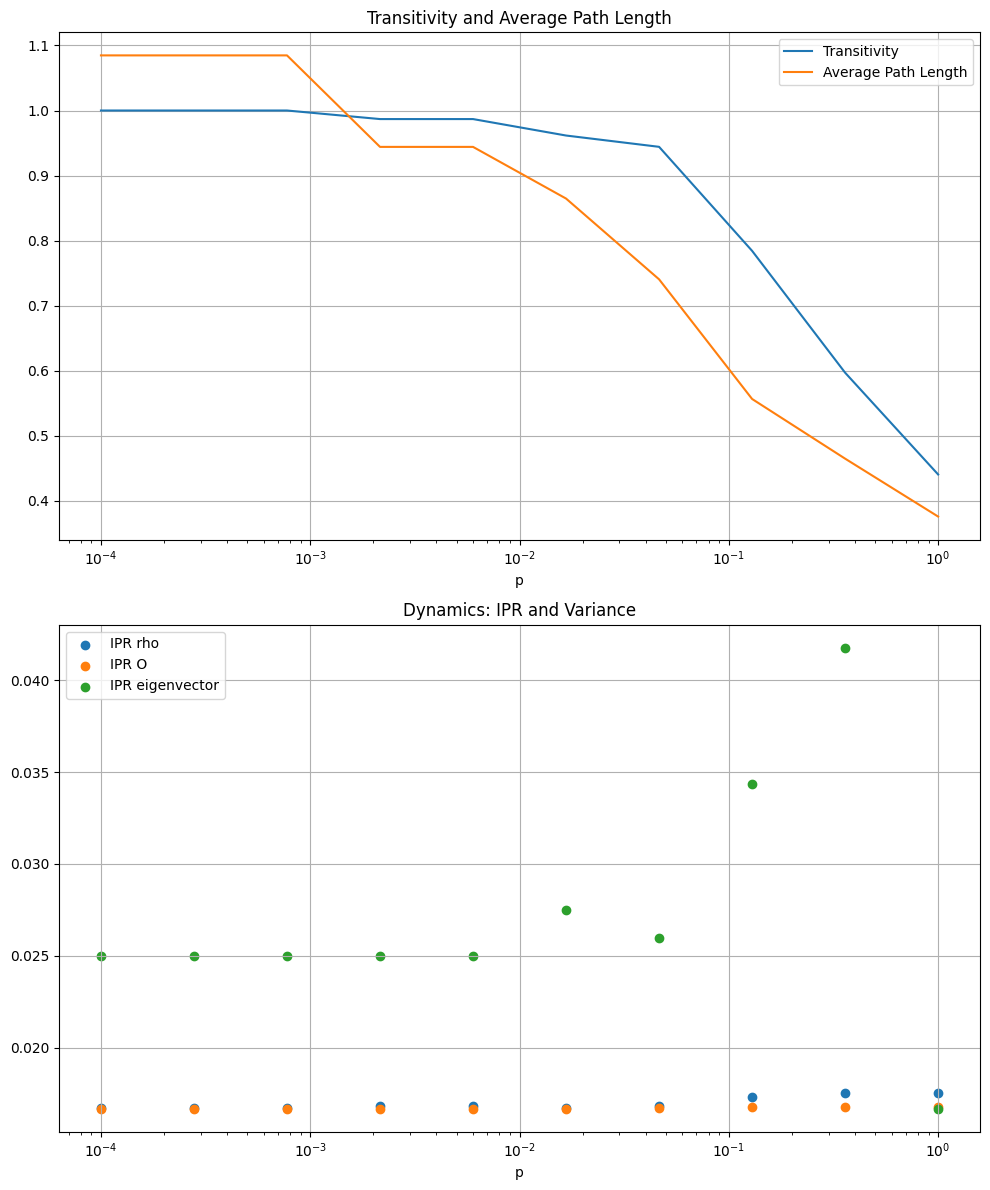

{'dynamics_data': {np.float64(0.0001): [{'critical_eigenvalue': -1.3042824740748493, 'last_values_rho': [0.00795842978846199, 0.007923328211815888, 0.007925317354648428, 0.007930968310151222, 0.00791875687700695, 0.00792190319675072, 0.007933689568627689, 0.007947415106614673, 0.007957973777391047, 0.007956240175735476, 0.007954798447330345, 0.007952958239311848, 0.007945017766758773, 0.007937804985162462, 0.007916861593633818, 0.007900730782842544, 0.007804141550367205, 0.007530758296423276, 0.007892120897129066, 0.007932572306233919, 0.007939398073650218, 0.007939652294769488, 0.00793495473900577, 0.007943099667445856, 0.007940355849914761, 0.007937651842056491, 0.00793693195821723, 0.007942855506799464, 0.007938476946745824, 0.007940083686806952, 0.007943663146474466, 0.007939377350729419, 0.007941288965816525, 0.007938349869870921, 0.007938218278044891, 0.00793405278696119, 0.00793293217817222, 0.007939470154925916, 0.00794257869574468, 0.007942481565584684, 0.007939924342635782, 0

In [15]:
experiment = experiments(60, 6, 10, 1, params)
print(experiment)